# Transducing Language Models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transduction import (
    FST, EPSILON, PrecoverDecomp, examples, check_properties,
    LazyRecursive, BuggyLazyRecursive, EagerNonrecursive, LazyPrecoverNFA, LazyNonrecursive,    
)
from transduction.util import display_table

### Notes

$$\mathcal{P}(\boldsymbol{y}) = \mathcal{Q}(\boldsymbol{y}) \mathcal{X}^* \sqcup \mathcal{R}(\boldsymbol{y})$$

For all $\boldsymbol{y}, \boldsymbol{y}' \in \mathcal{Y}^*$
$$\mathcal{P}(\boldsymbol{y}) \supseteq \mathcal{P}(\boldsymbol{y} \, \boldsymbol{y}')$$


For all functional transducers, $\mathcal{P}(\varepsilon) = \mathcal{X}^*$

$$
\mathcal{P}(\boldsymbol{y} \, {\color{red}\boldsymbol{y}'}) = \{ \boldsymbol{x} \in \mathcal{P}(\boldsymbol{y}) \colon \underbrace{f(\boldsymbol{x}) \succeq  \boldsymbol{y}}_{\texttt{guaranteed}} \, {\color{red}\boldsymbol{y}'} \}
$$

In [3]:
from IPython.display import Latex, Markdown
display(Latex(LazyPrecoverNFA.__doc__))

<IPython.core.display.Latex object>

### A simple example

FST=


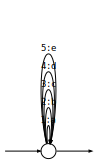

precover NFA=


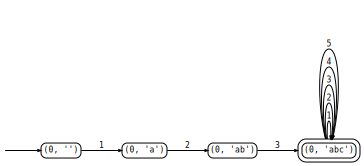

precover DFA=


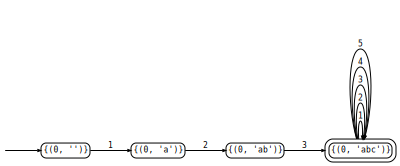

In [4]:
fst = examples.replace([('1', 'a'), ('2', 'b'), ('3', 'c'), ('4', 'd'), ('5', 'e')])
print('FST=')
display(fst)
tmp = LazyNonrecursive(fst)
assert tmp('abc') == ({'123'}, set())
print('precover NFA=')
display(tmp.nfa.materialize().graphviz(fmt_node=lambda x: x))
print('precover DFA=')
display(tmp.dfa.materialize().graphviz(fmt_node=set))

In [5]:
tmp = LazyRecursive(fst, max_steps=100)
assert tmp('abc') == ({'123'}, set())
#print('precover NFA=')
#display(tmp.nfa.materialize().graphviz(fmt_node=lambda x: x))
#print('precover DFA=')
#display(tmp.dfa.materialize().graphviz(fmt_node=set))

### Another simple example

This example shows how even a simple machine with a single state can lead to exponential summing in the length of the target string $\boldsymbol{y}$

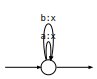

In [6]:
fst = examples.replace([('a', 'x'), ('b', 'x')])
fst

precover NFA=


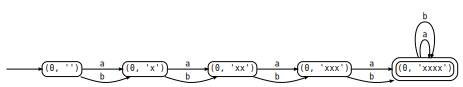

precover DFA=


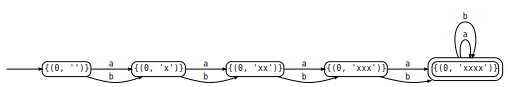

In [7]:
tmp = LazyNonrecursive(fst)
assert tmp('xxxx') == ({
    'aaaa', 'aaab', 'aaba', 'aabb', 'abaa', 'abab', 'abba', 'abbb', 
    'baaa', 'baab', 'baba', 'babb', 'bbaa', 'bbab', 'bbba', 'bbbb'
}, set())
print('precover NFA=')
display(tmp.nfa.materialize().graphviz(fmt_node=lambda x: x))
print('precover DFA=')
display(tmp.dfa.materialize().graphviz(fmt_node=set))

### Newspeak

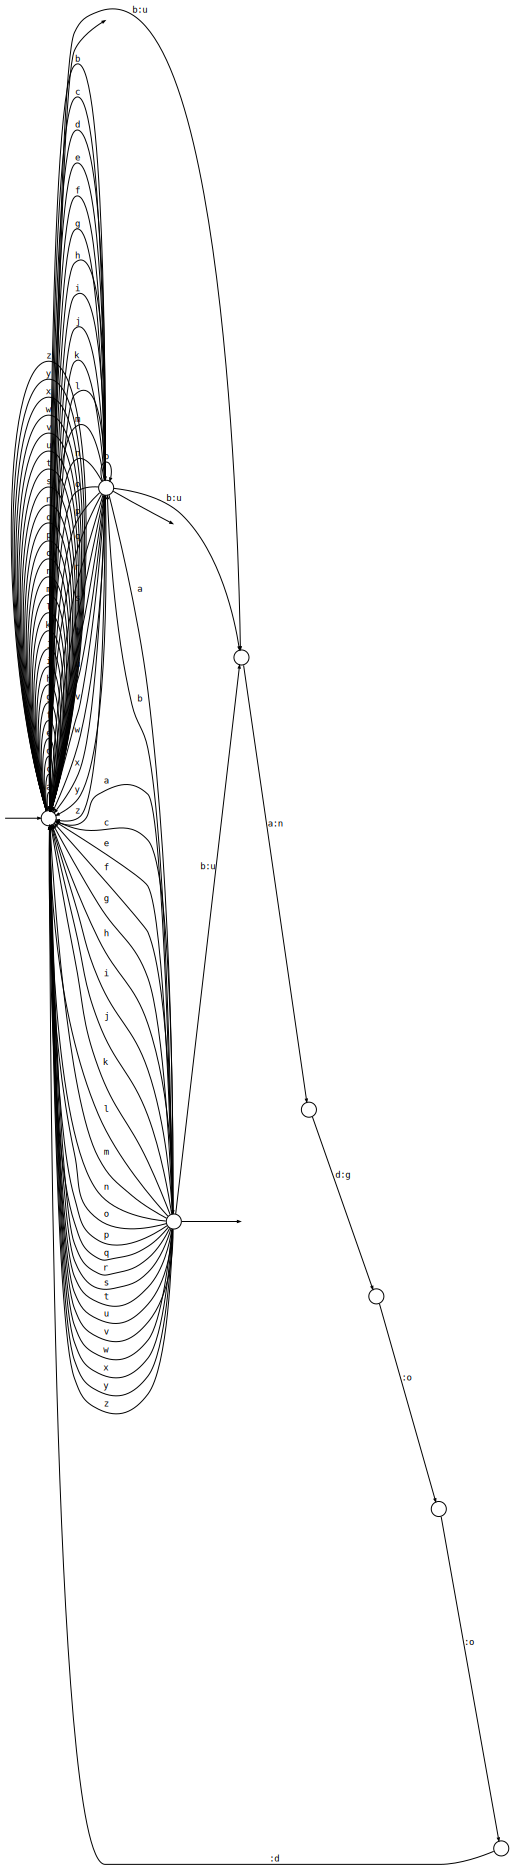

In [8]:
fst = examples.newspeak()
def fmt_edge(i,a,j):
    x,y = a
    if isinstance(x, int): x = str(bytes([x]))[2:-1]
    if isinstance(y, int): y = str(bytes([y]))[2:-1]
    return x if x == y else f'{x}:{y}'
fst.graphviz(fmt_edge=fmt_edge)

({b'bam', b'baj', b'bar', b'bav', b'bao', b'bax', b'baf', b'bai', b'bap', b'bah', b'bat', b'bak', b'baw', b'bau', b'bal', b'bae', b'baq', b'baa', b'bab', b'ban', b'bay', b'bac', b'bas', b'baz', b'bag'}, {b'ba'})
precover NFA=


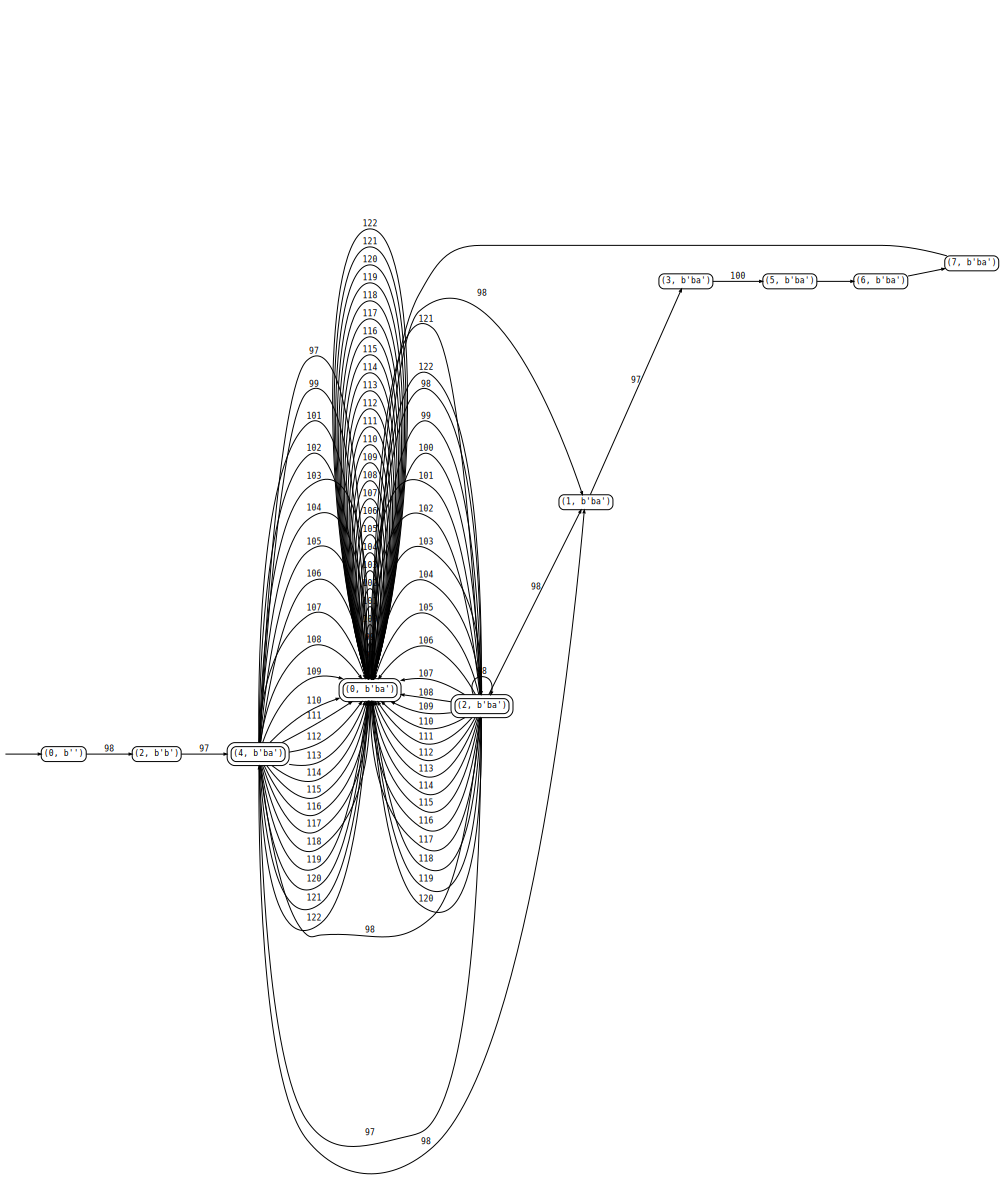

precover DFA=


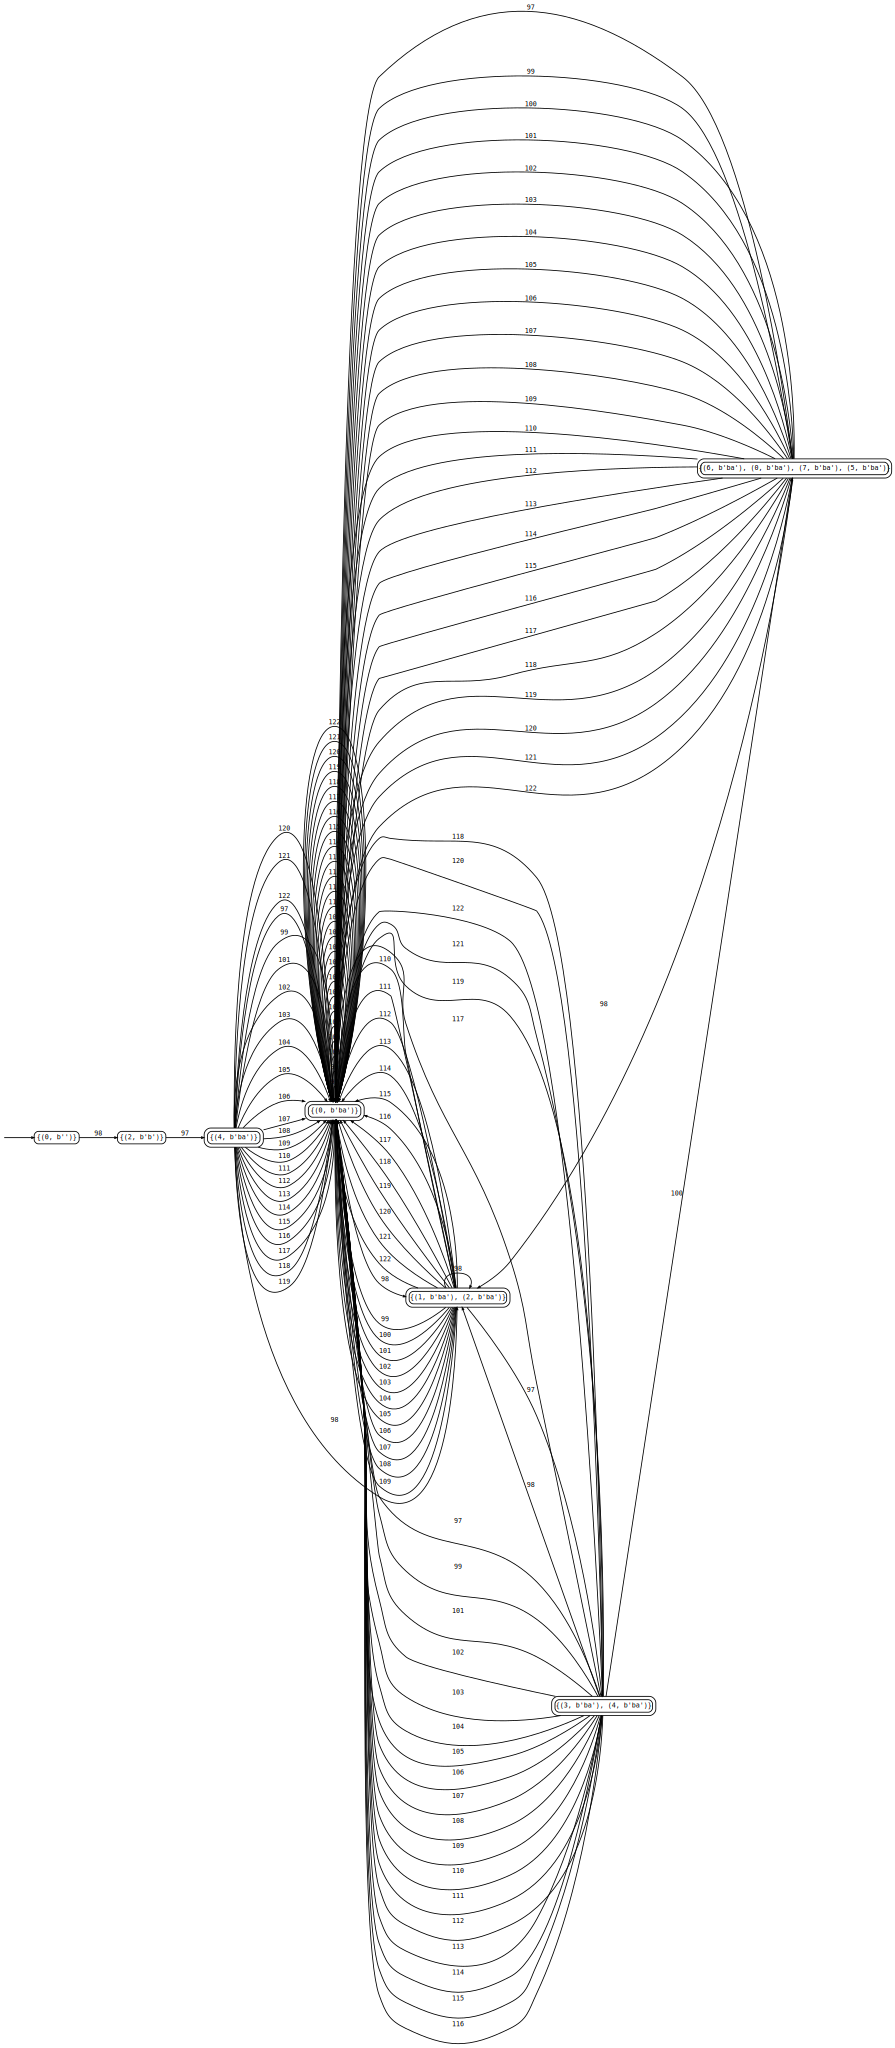

precover DFA=


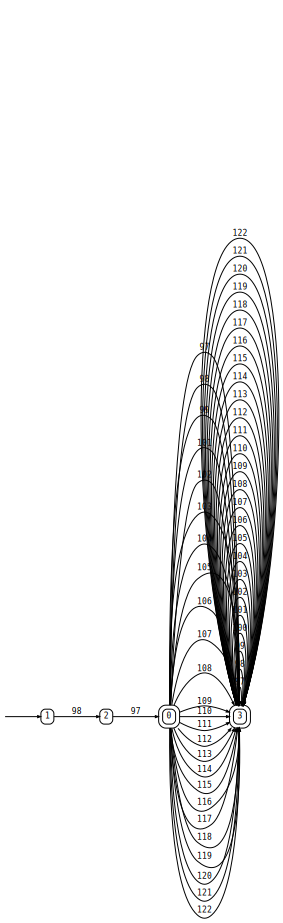

In [9]:
tmp = LazyNonrecursive(fst, max_steps=100, extend=lambda xs, x: bytes([*xs, x]), empty_source=b'')
target = b'ba'
output = tmp(target)
print(output)
print('precover NFA=')
display(tmp.nfa.materialize().graphviz(fmt_node=lambda x: x))
print('precover DFA=')
display(tmp.dfa.materialize().graphviz(fmt_node=set))
print('precover DFA=')
display(tmp.dfa.materialize().min())

In [10]:
assert output == ({
    b'baa', b'bag', b'bak', b'bay', b'baw', b'baq', b'bac', b'ban', b'bah', 
    b'baz', b'bav', b'bal', b'bau', b'bap', b'bae', b'bar', b'bai', b'bam', 
    b'bao', b'bab', b'baf', b'bat', b'baj', b'bax', b'bas'
}, {b'ba'})

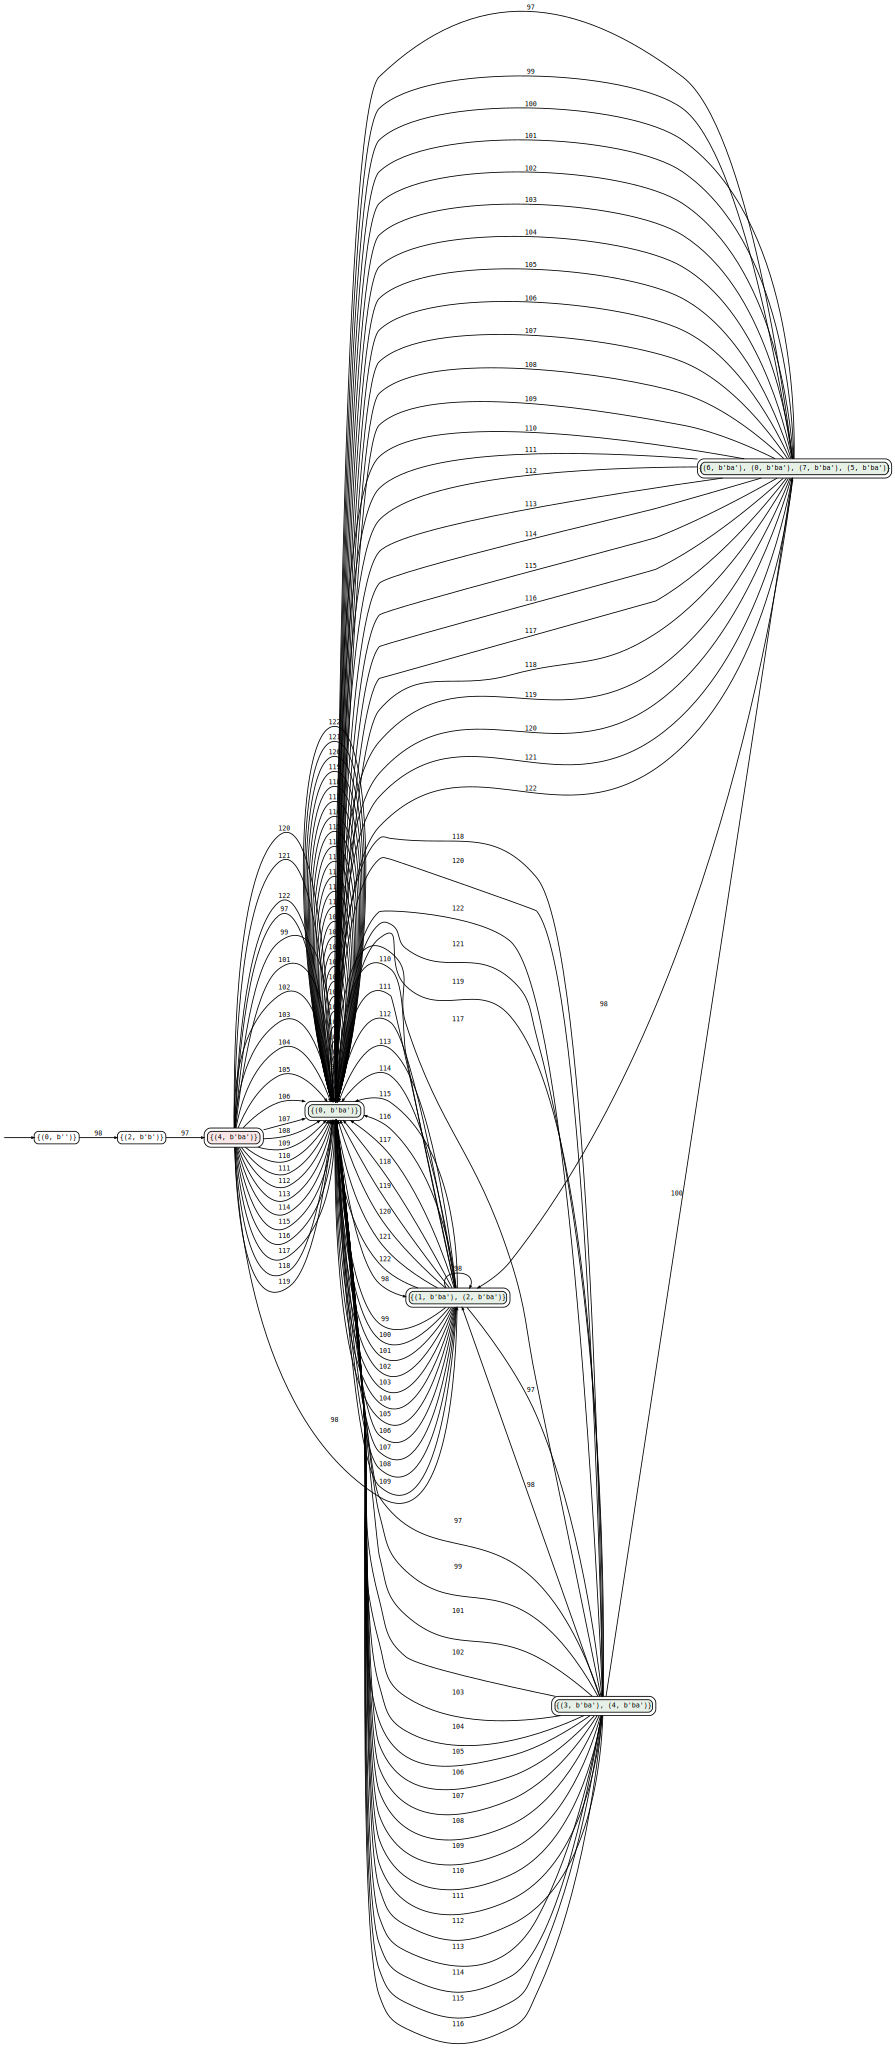

In [11]:
dfa = tmp.dfa.materialize()
display(dfa.graphviz(fmt_node=set, sty_node=lambda x: {'style': 'filled,rounded', 
                                                       'fillcolor': '#E6F0E6' if tmp.dfa.accepts_universal(x, tmp.source_alphabet) else
                                                       ('#F9E6E6' if tmp.dfa.is_final(x) else 'white')}))

### Parity: an example of infinite remainder

FST=


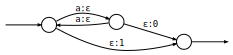

stopped early
(set(), {'a', 'aaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaa', 'aaaaaaaaa', 'aaaaa', 'aaaaaaaaaaaaa', 'aaaaaaa', 'aaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaaaaaaa'})
precover NFA=


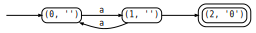

precover DFA=


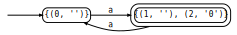

P=


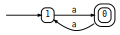

Q=


'empty'

R=


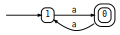

In [12]:
fst = examples.parity({'a'})

print('FST=')
display(fst)
tmp = LazyNonrecursive(fst, max_steps=20)
target = '0'
output = tmp(target)
print(output)
print('precover NFA=')
display(tmp.nfa.materialize().graphviz(fmt_node=lambda x: x))
print('precover DFA=')
display(tmp.dfa.materialize().graphviz(fmt_node=set))

P = EagerNonrecursive(fst).precover_dfa(target)
Q, R = EagerNonrecursive(fst).decompose_fsa(target)
print('P=')
display(P)
print('Q=')
display(Q if len(Q.nodes) > 0 else 'empty')
print('R=')
display(R)

### The importance of weight pushing

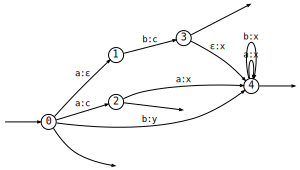

In [13]:
sam = examples.samuel_example()
sam.graphviz(fmt_node=lambda x: x)

In [14]:
# def paths(self):
#     worklist = []
#     for i, _ in self.I:
#         worklist.append((i,))
#     while worklist:
#         path = worklist.pop(0)
#         i = path[-1]
#         if self.stop[i] > 0:
#             yield path
#         for (a, b), j, w in self.arcs(i):
#             worklist.append(path + ((a,b), j))
#     return m

In [15]:
# from arsenal.iterextras import take
# list(take(20, paths(sam)))

FST=


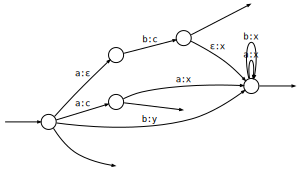

decomp: ({'a'}, set())
check properties:
├─ valid: ✔ equal to precover
├─ quotient:
├─ ✔ 'a' is a valid cylinder
└─ overall: ✔
precover NFA=


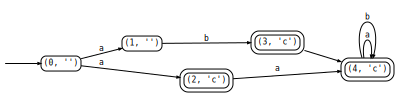

precover DFA=


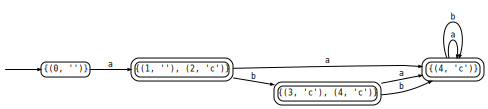

precover minimal DFA=


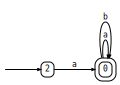

In [16]:
fst = sam
target = 'c'
print('FST=')
display(fst)
tmp = LazyNonrecursive(fst)
have = tmp(target)
print('decomp:', have)
check_properties(fst, target, *have)
#assert have == ({'a'}, set())
print('precover NFA=')
display(tmp.nfa.materialize().graphviz(fmt_node=lambda x: x))
print('precover DFA=')
display(tmp.dfa.materialize().graphviz(fmt_node=set))
print('precover minimal DFA=')
display(tmp.dfa.materialize().min())

On this example, `Foo` finds a valid, but suboptimal cover

In [17]:
foo = BuggyLazyRecursive(sam)
target = 'c'
decomp = foo(target)
assert decomp == ({'aa', 'ab'}, {'a'}), decomp   # suboptimal, but valid decomposition
check_properties(sam, target, *decomp)

check properties:
├─ valid: ✔ equal to precover
├─ quotient:
├─ ✔ 'aa' is a valid cylinder
├─ ✘ 'aa' is not minimal because its strict prefix 'a' is a cylinder of the precover
├─ ✔ 'ab' is a valid cylinder
├─ ✘ 'ab' is not minimal because its strict prefix 'a' is a cylinder of the precover
├─ remainder:
├─ ✘ 'a' in precover and not a cylinder
└─ overall: ✘


In [18]:
moo = foo._as_fsa(target)
display_table([[
    moo.graphviz(fmt_node=lambda x: foo.frontier(x),
                 sty_node=lambda x: {'style': 'filled,rounded', 
                                     'fillcolor': '#E6F0E6' if foo.continuity(x, target) else ('#F9E6E6' if foo.discontinuity(x, target) else 'white')}
                ), 
    moo.graphviz(fmt_node=lambda x: x or 'ε'), 
    moo.min().graphviz(lambda x: '')
]], headings=['states', 'strings', 'minimized'])

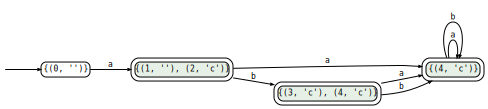

In [19]:
tmp = LazyNonrecursive(sam)
assert tmp(target) == ({'a'}, set())
dfa = tmp.dfa.materialize()
display(dfa.graphviz(fmt_node=set, sty_node=lambda x: {'style': 'filled,rounded', 
                                                       'fillcolor': '#E6F0E6' if tmp.dfa.accepts_universal(x, tmp.source_alphabet) else
                                                       ('#F9E6E6' if tmp.dfa.is_final(x) else 'white')}))

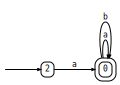

In [20]:
tmp.dfa.materialize().min()

In [21]:
check_properties(sam, 'c', *EagerNonrecursive(sam, max_steps=25)('c'))

check properties:
├─ valid: ✔ equal to precover
├─ quotient:
├─ ✔ 'a' is a valid cylinder
└─ overall: ✔


In [22]:
QQ,RR = EagerNonrecursive(sam, max_steps=25).decompose_fsa('c')
print('Q=')
display(QQ)
print('R=')
display(RR if len(RR.nodes) > 0 else 'empty')

Q=


R=


'empty'

In [23]:
check_properties(sam, 'c', *BuggyLazyRecursive(sam)('c'))

check properties:
├─ valid: ✔ equal to precover
├─ quotient:
├─ ✔ 'aa' is a valid cylinder
├─ ✘ 'aa' is not minimal because its strict prefix 'a' is a cylinder of the precover
├─ ✔ 'ab' is a valid cylinder
├─ ✘ 'ab' is not minimal because its strict prefix 'a' is a cylinder of the precover
├─ remainder:
├─ ✘ 'a' in precover and not a cylinder
└─ overall: ✘


In [24]:
assert LazyRecursive(sam, max_steps=100)(target) == ({'a'}, set())

### Samuel's first PTB rule example

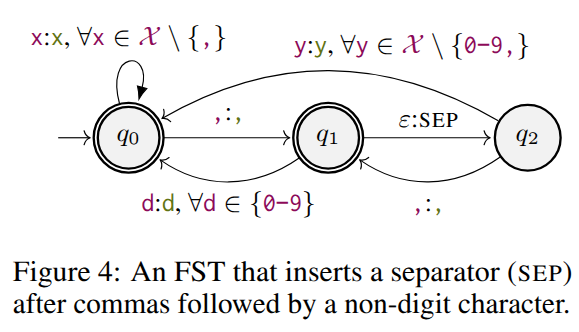

In [25]:
import string
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [26]:
#digits = {'0','1'}
#m = number_comma_separator(
#    digits | {','} | {'x', 'y', 'z'}, 
#    Digit = digits,
#)
digits = {str(i) for i in range(10)}
#m = number_comma_separator(digits | {','} | {'x', 'y', 'z'})
m = examples.number_comma_separator(set(string.printable) - set('\t\n\r\x0b\x0c'))
X = m.A
#m.graphviz(fmt_node=lambda x: x)

In [27]:
# def apply(m, x):
#     assert set(x) <= X
#     results = [''.join(y) for y in m(x, None).epsremove.trim.to_cfg().language(100).keys()]
#     assert len(results) == 1, results
#     return results[0]    

In [28]:
# assert apply(m, '') == ''
# assert apply(m, '1,1,,') == '1,1,|,'
# assert apply(m, '1') == '1'
# assert apply(m, ',,,') == ',|,|,'
# assert apply(m, '100,') == '100,'   
# assert apply(m, '100, ') == '100,| '
# assert apply(m, '3,50') == '3,50'
# assert apply(m, ',00,') == ',00,'
# assert apply(m, '123') == '123'
# assert apply(m, '1,2,3') == '1,2,3'
# assert apply(m, '1, 2, 3') == '1,| 2,| 3'
# assert apply(m, '1, 2, and 3') == '1,| 2,| and 3'

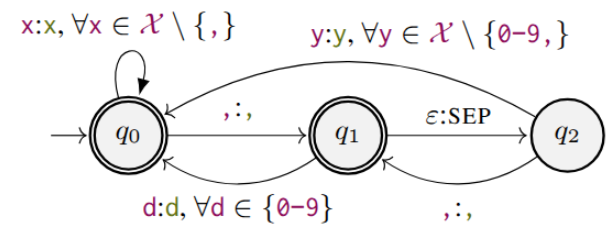

In [29]:
tmp = LazyNonrecursive(m)
assert tmp('1,| 2,| and 3') == ({'1, 2, and 3'}, set())

In [30]:
have = tmp('1,| 2,|')
want = ({'1, 2,' + x for x in tmp.source_alphabet if x not in '1234567890'}, set())
#print(have.quotient)
#print(want[0])
#print(have.quotient - want[0])
#print(want[0] - have.quotient)
assert have == want

In [31]:
target_prefix = '1,| 2,'
for y in tmp.target_alphabet:
    Q,R = tmp(target_prefix+y)
    assert len(R) == 0
    if y == '|' and target_prefix.endswith(','):
        assert len(Q) == len(tmp.source_alphabet) - len(digits), [target_prefix, y, Q]
    else:
        assert len(Q) <= 1, [target_prefix, y, Q]
    if len(Q) > 0:
        print(repr(y), Q)

'9' {'1, 2,9'}
'0' {'1, 2,0'}
'1' {'1, 2,1'}
'4' {'1, 2,4'}
'3' {'1, 2,3'}
'8' {'1, 2,8'}
'6' {'1, 2,6'}
'|' {'1, 2,K', '1, 2,.', '1, 2,p', '1, 2,U', '1, 2,q', '1, 2,`', '1, 2,S', '1, 2,&', '1, 2,)', '1, 2,a', '1, 2,:', '1, 2,w', '1, 2,$', '1, 2,@', '1, 2,|', '1, 2,g', '1, 2,b', '1, 2, ', '1, 2,R', '1, 2,z', '1, 2,<', "1, 2,'", '1, 2,n', '1, 2,Q', '1, 2,G', '1, 2,m', '1, 2,Z', '1, 2,k', '1, 2,u', '1, 2,]', '1, 2,y', '1, 2,%', '1, 2,N', '1, 2,+', '1, 2,E', '1, 2,s', '1, 2,o', '1, 2,#', '1, 2,B', '1, 2,j', '1, 2,h', '1, 2,l', '1, 2,=', '1, 2,(', '1, 2,D', '1, 2,>', '1, 2,H', '1, 2,X', '1, 2,v', '1, 2,F', '1, 2,M', '1, 2,c', '1, 2,-', '1, 2,{', '1, 2,J', '1, 2,[', '1, 2,~', '1, 2,d', '1, 2,^', '1, 2,t', '1, 2,C', '1, 2,V', '1, 2,*', '1, 2,}', '1, 2,\\', '1, 2,O', '1, 2,A', '1, 2,W', '1, 2,L', '1, 2,i', '1, 2,T', '1, 2,I', '1, 2,;', '1, 2,_', '1, 2,Y', '1, 2,f', '1, 2,P', '1, 2,r', '1, 2,e', '1, 2,"', '1, 2,/', '1, 2,,', '1, 2,!', '1, 2,x', '1, 2,?'}
'7' {'1, 2,7'}
'5' {'1, 2,5'}
'2' {'1, 

### Samuel's second PTB rule

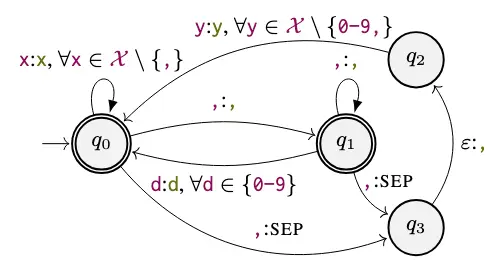!

```
Input: 'a,a ' -> Output: 'a_,a'
Input: 'a,1 ' -> Output: 'a,1'
Input: '1,1 ' -> Output: '1,1'
Input: '1,a ' -> Output: '1_,a'
```